# Random Forest
Equus, bowtie, transcripts.

In [1]:
from datetime import datetime
print(datetime.now())

2023-07-08 15:46:52.023939


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/IRP2/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/IRP2/Models/'  # must end in "/"
except:
    IN_COLAB = False
    print('Running on Mac')
    DATA_DIR="/Users/jasonmiller/WVU/BAM_ML/"
    MODEL_DIR="/Users/jasonmiller/WVU/BAM_ML/Models/"
SAVE_MODEL_FILENAME = None

GPU device not found
Running on CoLab
Mounted at /content/drive/


In [3]:
from platform import python_version
print('Python',python_version())
import random
import numpy as np
np.random.seed(42) # supposedly sets scikit-learn
import pandas as pd  # for plotting
import time # sleep function
from os.path import isfile
import gzip
from matplotlib import pyplot as plt
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
# consider sklearn.metrics.classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC

EPOCHS=150

Python 3.10.12
sklearn 1.2.2


## Data Load

In [4]:
MAX_LINES_TO_LOAD =    1000000 # training - 1M lines requires 2GB RAM
#MAX_LINES_TO_LOAD =    10000 # use this for debugging

VALID_PORTION = 0.20

DATA_FILE_0 = 'Equus/Bowtie/asinus/read_stats.csv.gz'
DATA_FILE_1 = 'Equus/Bowtie/caballus/read_stats.csv.gz'

print('Data directory: %s'%DATA_DIR)
print('Data file 0 %s'%DATA_FILE_0)
print('Data file 1 %s'%DATA_FILE_1)
print('Input lines for training: %d'%MAX_LINES_TO_LOAD)

Data directory: /content/drive/My Drive/data/IRP2/
Data file 0 Equus/Bowtie/asinus/read_stats.csv.gz
Data file 1 Equus/Bowtie/caballus/read_stats.csv.gz
Input lines for training: 1000000


In [5]:
# P1 parent 1
# R1 read 1
# PS primary or secondary
# AS bowtie alignment score (0 is best)
# ED edit distance
# MM mismatch count
# GO gap open count
# GE gap extend count
feature_names = [
    'P1 R1 AS',
    'P1 R1 ED',
    'P1 R1 MAT',
    'P1 R1 MM',
    'P1 R1 HQMM',
    'P1 R1 GO',
    'P1 R1 GE',
    'P1 R1 INS',
    'P1 R1 DELS',
    'P1 R1 HQINS',
    'P1 R1 HQDEL',
    'P1 R2 AS',
    'P1 R2 ED',
    'P1 R2 MAT',
    'P1 R2 MM',
    'P1 R2 HQMM',
    'P1 R2 GO',
    'P1 R2 GE',
    'P1 R2 INS',
    'P1 R2 DELS',
    'P1 R2 HQINS',
    'P1 R2 HQDEL',
    'P2 R1 AS',
    'P2 R1 ED',
    'P2 R1 MAT',
    'P2 R1 MM',
    'P2 R1 HQMM',
    'P2 R1 GO',
    'P2 R1 GE',
    'P2 R1 INS',
    'P2 R1 DELS',
    'P2 R1 HQINS',
    'P2 R1 HQDEL',
    'P2 R2 AS',
    'P2 R2 ED',
    'P2 R2 MAT',
    'P2 R2 MM',
    'P2 R2 HQMM',
    'P2 R2 GO',
    'P2 R2 GE',
    'P2 R2 INS',
    'P2 R2 DELS',
    'P2 R2 HQINS',
    'P2 R2 HQDEL',
    'R1 length',
    'R2 length',
    'P1 span',
    'P2 span',
    'Span diff',
    'AS diff',
    'ED diff',
    'MAT diff',
    'MM diff',
    'HQMM diff',
    'GO diff',
    'GE diff',
    'INS diff',
    'DELS diff',
    'HQINS diff',
    'HQDEL diff',
    'PARENT']
print('Total feature names: ',len(feature_names))
for i in range(len(feature_names)):
    print(i,feature_names[i])

Total feature names:  61
0 P1 R1 AS
1 P1 R1 ED
2 P1 R1 MAT
3 P1 R1 MM
4 P1 R1 HQMM
5 P1 R1 GO
6 P1 R1 GE
7 P1 R1 INS
8 P1 R1 DELS
9 P1 R1 HQINS
10 P1 R1 HQDEL
11 P1 R2 AS
12 P1 R2 ED
13 P1 R2 MAT
14 P1 R2 MM
15 P1 R2 HQMM
16 P1 R2 GO
17 P1 R2 GE
18 P1 R2 INS
19 P1 R2 DELS
20 P1 R2 HQINS
21 P1 R2 HQDEL
22 P2 R1 AS
23 P2 R1 ED
24 P2 R1 MAT
25 P2 R1 MM
26 P2 R1 HQMM
27 P2 R1 GO
28 P2 R1 GE
29 P2 R1 INS
30 P2 R1 DELS
31 P2 R1 HQINS
32 P2 R1 HQDEL
33 P2 R2 AS
34 P2 R2 ED
35 P2 R2 MAT
36 P2 R2 MM
37 P2 R2 HQMM
38 P2 R2 GO
39 P2 R2 GE
40 P2 R2 INS
41 P2 R2 DELS
42 P2 R2 HQINS
43 P2 R2 HQDEL
44 R1 length
45 R2 length
46 P1 span
47 P2 span
48 Span diff
49 AS diff
50 ED diff
51 MAT diff
52 MM diff
53 HQMM diff
54 GO diff
55 GE diff
56 INS diff
57 DELS diff
58 HQINS diff
59 HQDEL diff
60 PARENT


In [6]:
class DataLoader():
    def __init__(self,filepath1,filepath2,verbose=True):
        self.files = [filepath1,filepath2]
        self.alignments=[]
        self.labels=[]
        self.verbose = verbose
        self.max_lines = None
        self.ties = 0
        self.predictions = []

    def set_max_lines(self,lines):
        '''Limit the dataset size to fit in RAM.'''
        self.max_lines = lines
        if self.verbose:
            print('Maximum lines to load per file: %d'%lines)

    def _count_lines_(self):
        '''Show number of lines per input file.'''
        count0 = 0
        with gzip.open (self.files[0],'rt') as handle0:
            for row in handle0:
                count0 += 1
        count1 = 0
        with gzip.open(self.files[1],'rt') as handle1:
            for row in handle1:
                count1 += 1
        minimum = min(count0,count1)
        if self.verbose:
            print('File0 size: %d %s'%(count0,self.files[0]))
            print('File1 size: %d %s'%(count1,self.files[1]))
        return minimum

    def _load_line_(self,row):
        '''Load data structure from one line of CSV file.'''
        line = row.strip()
        fields = line.split(',')
        ints = [0] * 61
        # These fields come straight from the input file.
        # These fields are grouped by which read they describe.
        # P1 R1 = Parent 1, Read 1
        ints[0] = int(fields[0]) # P1 R1 AS
        ints[1] = int(fields[1]) # P1 R1 ED
        ints[2] = int(fields[2]) # P1 R1 MAT
        ints[3] = int(fields[3]) # P1 R1 MM
        ints[4] = int(fields[4]) # P1 R1 HQMM
        ints[5] = int(fields[5]) # P1 R1 GO
        ints[6] = int(fields[6]) # P1 R1 GE
        ints[7] = int(fields[7]) # P1 R1 INS
        ints[8] = int(fields[8]) # P1 R1 DELS
        ints[9] = int(fields[9]) # P1 R1 HQINS
        ints[10] = int(fields[10]) # P1 R1 HQDEL
        # P1 R2 = Parent 1, Read 2
        ints[11] = int(fields[11]) # P1 R2 AS
        ints[12] = int(fields[12]) # P1 R2 ED
        ints[13] = int(fields[13]) # P1 R2 MAT
        ints[14] = int(fields[14]) # P1 R2 MM
        ints[15] = int(fields[15]) # P1 R2 HQMM
        ints[16] = int(fields[16]) # P1 R2 GO
        ints[17] = int(fields[17]) # P1 R2 GE
        ints[18] = int(fields[18]) # P1 R2 INS
        ints[19] = int(fields[19]) # P1 R2 DELS
        ints[20] = int(fields[20]) # P1 R2 HQINS
        ints[21] = int(fields[21]) # P1 R2 HQDEL
        # P2 R1 = Parent 2, Read 1
        ints[22] = int(fields[22]) # P2 R1 AS
        ints[23] = int(fields[23]) # P2 R1 ED
        ints[24] = int(fields[24]) # P2 R1 MAT
        ints[25] = int(fields[25]) # P2 R1 MM
        ints[26] = int(fields[26]) # P2 R1 HQMM
        ints[27] = int(fields[27]) # P2 R1 GO
        ints[28] = int(fields[28]) # P2 R1 GE
        ints[29] = int(fields[29]) # P2 R1 INS
        ints[30] = int(fields[30]) # P2 R1 DELS
        ints[31] = int(fields[31]) # P2 R1 HQINS
        ints[32] = int(fields[32]) # P2 R1 HQDEL
        # P2 R2 = Parent 2, Read 2
        ints[33] = int(fields[33]) # P2 R2 AS
        ints[34] = int(fields[34]) # P2 R2 ED
        ints[35] = int(fields[35]) # P2 R2 MAT
        ints[36] = int(fields[36]) # P2 R2 MM
        ints[37] = int(fields[37]) # P2 R2 HQMM
        ints[38] = int(fields[38]) # P2 R2 GO
        ints[39] = int(fields[39]) # P2 R2 GE
        ints[40] = int(fields[40]) # P2 R2 INS
        ints[41] = int(fields[41]) # P2 R2 DELS
        ints[42] = int(fields[42]) # P2 R2 HQINS
        ints[43] = int(fields[43]) # P2 R2 HQDEL
        # Fields that come in twos
        ints[44] = int(fields[44]) # R1 length (of read)
        ints[45] = int(fields[45]) # R2 length (of read)
        ints[46] = int(fields[46]) # P1 span (of mapped read pair)
        ints[47] = int(fields[47]) # P2 span (of mapped read pair)
        # Read-wise differences
        ints[48] = ints[47]-ints[46] # P2-P1 span diff
        ints[49] = (ints[33]+ints[22])-(ints[11]+ints[0]) # AS diff
        ints[50] = (ints[34]+ints[23])-(ints[12]+ints[1]) # ED diff
        ints[51] = (ints[35]+ints[24])-(ints[13]+ints[2]) # MAT diff
        ints[52] = (ints[36]+ints[25])-(ints[14]+ints[3]) # MM diff
        ints[53] = (ints[37]+ints[26])-(ints[15]+ints[4]) # HQMM diff
        ints[54] = (ints[38]+ints[27])-(ints[16]+ints[5]) # GO diff
        ints[55] = (ints[39]+ints[28])-(ints[17]+ints[6]) # GE diff
        ints[56] = (ints[40]+ints[29])-(ints[18]+ints[7]) # INS diff
        ints[57] = (ints[41]+ints[30])-(ints[19]+ints[8]) # DELS diff
        ints[58] = (ints[42]+ints[31])-(ints[20]+ints[9]) # HQINS diff
        ints[59] = (ints[43]+ints[32])-(ints[21]+ints[10]) # HQDEL diff
        # The feature-extraction program populated fields[36]
        # to indicate which parent had higher alignment score.
        # Values were 0=same, 1=parent1, 2=parent2.
        # We change the values to -1=parent1, 0=unknown, +1=parent2
        parent_choice = int(fields[48])
        if parent_choice == 1:
            ints[60] = -1  # not parent 2
        elif parent_choice == 2:
            ints[60] = 1  # is parent 2
        elif parent_choice == 0:
            ints[60] = 0
        else:
            raise Exception('Unrecognized parent choice:'+str(parent_choice))
        # For fair comparison, force aligner to choose.
        # We change 1 to 0, 2 to 1, and 0 to 1 or 2 randomly.
        # TO DO: faster alternative to list.append() ???
        parent_choice = int(fields[48])
        if parent_choice == 1:
            self.predictions.append(0)  # not parent 2
        elif parent_choice == 2:
            self.predictions.append(1)  # is parent 2
        else: # parent_choice == 0:
            self.ties += 1
            guess = random.randint(0,1)
            self.predictions.append(guess)
        # The transcript that this read pair aligned to.
        # This is for pipelines that only process reads that map
        # to same transcript in both parents and (filter the others).
        # Pipelines that assign reads to parent, regardless of which gene,
        # should ignore this value. (It only reflects first parent map anyway.)
        transcript_id = fields[49] # TO DO: where to put this?
        self.alignments.append(ints)

    def count_ties(self):
        return self.ties

    def load_full_train_set(self):
        '''Load full train set (to be used for train and valiation).
           Use set_max_lines() to leave some data for the test set.'''
        minimum = 0
        train_size = self.max_lines
        if self.verbose:
            print('Trying to load %d lines per file...'%train_size)
        try:
            handle0 = gzip.open(self.files[0],'rt')
            handle1 = gzip.open(self.files[1],'rt')
            # Associate label 0 with data from file 0. Same for 1.
            for i in range(train_size):
                row = next(handle0)
                self._load_line_(row)
                self.labels.append(0)
                row = next(handle1)
                self._load_line_(row)
                self.labels.append(1)
            handle0.close()
            handle1.close()
        except Exception as e:
            print(e)
            print('Most likely, one file has too few reads.')
            raise Exception('CANNOT LOAD DATA FROM FILE!')

    def show_examples(self,head=6):
        head = min(head,len(self.alignments))
        for i in range(head):
            print('From '+self.files[self.labels[i]])
            print('Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL')
            print(self.alignments[i][0:11])
            print(self.alignments[i][11:22])
            print(self.alignments[i][22:33])
            print(self.alignments[i][33:44])

    def get_X_y(self):
        loaded = len(self.alignments)
        divider = int(loaded - loaded * VALID_PORTION)
        X_train = np.array(self.alignments[:divider])
        y_train = np.array(self.labels[:divider])
        X_valid = np.array(self.alignments[divider:])
        y_valid = np.array(self.labels[divider:])
        if self.verbose:
            print('Full train set size = '+str(len(self.alignments)))
            print('Training/Validation partition: %d/%d'%(len(y_train),len(y_valid)))
        return X_train,y_train, X_valid,y_valid

    def get_predictions(self):
        loaded = len(self.predictions)
        divider = int(loaded - loaded * VALID_PORTION)
        y_train = self.predictions[:divider]
        y_valid = self.predictions[divider:]
        return y_train, y_valid

In [7]:
print(datetime.now())
filepath0 = DATA_DIR+DATA_FILE_0
filepath1 = DATA_DIR+DATA_FILE_1
loader=DataLoader(filepath0,filepath1)
loader.set_max_lines(MAX_LINES_TO_LOAD)
print('LOADING')
loader.load_full_train_set()
print('Number of ties: %d' % loader.count_ties())
aligner_predictions_train, aligner_predictions_valid = loader.get_predictions()
print(datetime.now())
loader.show_examples()

2023-07-08 15:47:15.420927
Maximum lines to load per file: 1000000
LOADING
Trying to load 1000000 lines per file...
Number of ties: 746371
2023-07-08 15:47:54.735350
From /content/drive/My Drive/data/IRP2/Equus/Bowtie/asinus/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[0, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 54, 0, 0, 0, 0, 0, 0, 0, 0]
From /content/drive/My Drive/data/IRP2/Equus/Bowtie/caballus/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[-11, 3, 148, 3, 0, 0, 0, 0, 0, 0, 0]
[-5, 1, 149, 1, 0, 0, 0, 0, 0, 0, 0]
[-1, 1, 150, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 150, 0, 0, 0, 0, 0, 0, 0, 0]
From /content/drive/My Drive/data/IRP2/Equus/Bowtie/asinus/read_stats.csv.gz
Score,Edit,MM,HQMM,GapOpen,GapExtend,HQINS,HQDEL
[-3, 1, 148, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 151, 0, 0, 0, 0, 0, 0, 0, 0]
[-3, 1, 148, 1, 0, 0, 0, 0, 0, 0, 0]
[-5, 1, 150, 1, 0, 0, 0, 0, 0, 0, 0]
From /content/drive

In [8]:
X_train,y_train, X_valid,y_valid = loader.get_X_y()
print('X train shape: ')
print(np.shape(X_train))
print('y train shape: ')
print(np.shape(y_train))
print('X valid shape: ')
print(np.shape(X_valid))
print('y valid shape: ')
print(np.shape(y_valid))

Full train set size = 2000000
Training/Validation partition: 1600000/400000
X train shape: 
(1600000, 61)
y train shape: 
(1600000,)
X valid shape: 
(400000, 61)
y valid shape: 
(400000,)


## Model

In [9]:
def build_model():
    rfc = RFC()
    return rfc

In [10]:
print(datetime.now())
rfc_model=build_model()
print(rfc_model)

2023-07-08 15:48:07.008043
RandomForestClassifier()


## Training

In [11]:
print(datetime.now())
print("FIT")
rfc_model.fit(X_train, y_train) # sample weight
print(datetime.now())

2023-07-08 15:48:07.024721
FIT
2023-07-08 15:53:46.058536


## Validation

In [12]:
print(datetime.now())
print("PREDICT")
yhat_pairs=rfc_model.predict_proba(X_valid)  # [ prob of 0, prob of 1 ]
yhat_pred=[pair[1] for pair in yhat_pairs]
yhat_classes=rfc_model.predict(X_valid)  # 0 or 1

print('debug pred',yhat_pred[:3])
print('debug class',yhat_classes[:3])
print(datetime.now())

2023-07-08 15:53:46.070339
PREDICT
debug pred [0.0, 0.87, 0.0]
debug class [0 1 0]
2023-07-08 15:54:20.406177


In [13]:
# docs: Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
def show_performance(y_valid, yhat_classes, yhat_pred):
    accuracy = accuracy_score(y_valid, yhat_classes)*100.
    precision = precision_score(y_valid, yhat_classes)*100.
    recall = recall_score(y_valid, yhat_classes)*100.
    sensitivity = recall_score(y_valid, yhat_classes, pos_label=1)*100.
    specificity = recall_score(y_valid, yhat_classes, pos_label=0)*100.
    f1 = f1_score(y_valid, yhat_classes)*100.
    mcc = matthews_corrcoef(y_valid, yhat_classes)
    if yhat_pred is None:
        # these stats are possible for probabilistic models only
        auprc = 0.
        auroc = 0.
    else:
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_valid, yhat_pred)*100.
    values,counts=np.unique(yhat_classes, return_counts=True)
    print('Predictions: ', dict(zip(values, counts)))
    print('Accuracy: %.2f%% F1: %.2f%% MCC: %.4f' % (accuracy,f1,mcc))
    print('Precision: %.2f%% Recall: %.2f%% AUPRC: %.2f%%' % (precision,recall,auprc))
    print('Sensitivity: %.2f%% Specificity: %.2f%% AUROC: %.2f%%' % (sensitivity,specificity,auroc))


In [14]:
print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
cm1 = confusion_matrix(y_valid,yhat_classes)
print('Confusion matrix\n',cm1)
cm2 = confusion_matrix(y_valid,yhat_classes,normalize='all')
print('Normalized matrix\n',cm2)

show_performance(y_valid, yhat_classes, yhat_pred)

Distrib of scores: 0.49959842866374815 mean 0.403643713155003 std
Range of scores: 0.0 to 1.0
Confusion matrix
 [[172714  27286]
 [ 27362 172638]]
Normalized matrix
 [[0.431785 0.068215]
 [0.068405 0.431595]]
Predictions:  {0: 200076, 1: 199924}
Accuracy: 86.34% F1: 86.34% MCC: 0.7268
Precision: 86.35% Recall: 86.32% AUPRC: 93.70%
Sensitivity: 86.32% Specificity: 86.36% AUROC: 93.79%


## Comparison

In [15]:
show_performance(y_valid, aligner_predictions_valid, None)

Predictions:  {0: 206807, 1: 193193}
Accuracy: 76.59% F1: 76.19% MCC: 0.5322
Precision: 77.53% Recall: 74.89% AUPRC: 0.00%
Sensitivity: 74.89% Specificity: 78.29% AUROC: 0.00%


## Feature Importance

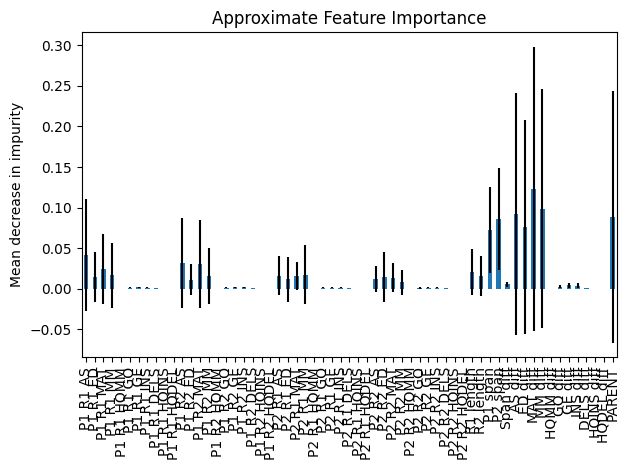

In [16]:
importances = rfc_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Approximate Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(forest_importances)

P1 R1 AS       0.041952
P1 R1 ED       0.014357
P1 R1 MAT      0.024017
P1 R1 MM       0.016271
P1 R1 HQMM     0.000000
P1 R1 GO       0.001003
P1 R1 GE       0.001505
P1 R1 INS      0.001366
P1 R1 DELS     0.000543
P1 R1 HQINS    0.000000
P1 R1 HQDEL    0.000000
P1 R2 AS       0.031799
P1 R2 ED       0.011182
P1 R2 MAT      0.030540
P1 R2 MM       0.015563
P1 R2 HQMM     0.000000
P1 R2 GO       0.000924
P1 R2 GE       0.001473
P1 R2 INS      0.001446
P1 R2 DELS     0.000592
P1 R2 HQINS    0.000000
P1 R2 HQDEL    0.000000
P2 R1 AS       0.016142
P2 R1 ED       0.011293
P2 R1 MAT      0.015569
P2 R1 MM       0.017170
P2 R1 HQMM     0.000000
P2 R1 GO       0.000913
P2 R1 GE       0.001324
P2 R1 INS      0.001271
P2 R1 DELS     0.000446
P2 R1 HQINS    0.000000
P2 R1 HQDEL    0.000000
P2 R2 AS       0.011892
P2 R2 ED       0.014657
P2 R2 MAT      0.013444
P2 R2 MM       0.008064
P2 R2 HQMM     0.000000
P2 R2 GO       0.000921
P2 R2 GE       0.001370
P2 R2 INS      0.001312
P2 R2 DELS     0

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    its = forest_importances.sort_values()
    print(its)

P2 R1 HQMM     0.000000
HQINS diff     0.000000
P2 R2 HQDEL    0.000000
P2 R2 HQINS    0.000000
P2 R2 HQMM     0.000000
P2 R1 HQDEL    0.000000
P2 R1 HQINS    0.000000
HQDEL diff     0.000000
P1 R2 HQDEL    0.000000
P1 R2 HQINS    0.000000
P1 R2 HQMM     0.000000
HQMM diff      0.000000
P1 R1 HQDEL    0.000000
P1 R1 HQMM     0.000000
P1 R1 HQINS    0.000000
P2 R2 DELS     0.000441
P2 R1 DELS     0.000446
P1 R1 DELS     0.000543
P1 R2 DELS     0.000592
DELS diff      0.000901
P2 R1 GO       0.000913
P2 R2 GO       0.000921
P1 R2 GO       0.000924
P1 R1 GO       0.001003
P2 R1 INS      0.001271
P2 R2 INS      0.001312
P2 R1 GE       0.001324
P1 R1 INS      0.001366
P2 R2 GE       0.001370
P1 R2 INS      0.001446
P1 R2 GE       0.001473
P1 R1 GE       0.001505
GO diff        0.002440
INS diff       0.003785
GE diff        0.004003
Span diff      0.005348
P2 R2 MM       0.008064
P1 R2 ED       0.011182
P2 R1 ED       0.011293
P2 R2 AS       0.011892
P2 R2 MAT      0.013444
P1 R1 ED       0